# 2021-07-30 • Inhibitory connections

Hello back.
We're re-running the simulation as before, only this time 'stimulating' our one Izhikevich neuron with inhibitory spike trains; that is: we'll lower the reversal potential of the synapse.

What we did previously: aggregate all incoming spikes together (in `N_to_1_experiment.simulate`), then use this one spike train to calculate a conductance signal (exp decay; in `synapses.py`); then feed this conductance signal to `sim_izh`, where a synaptic current `I_syn` is calculated as `g_syn[i] * (v[i] - v_syn)`, with `v_syn` a fixed synaptic reversal potential.

We'll need to change this architecture:
- We have to calculate a conductance signal for every incoming spike train separately (we can keep `synapses.py` as is).
- `sim_izh` needs to take not just one `g_syn` signal; but one for every spike train.
- `v_syn` is no longer a property of the neuron; it is a property of every incoming spike train.

Our new simulation code in the codebase will no longer work in older notebooks (but that's why we have git and the repro info).

Where to start? What is our eventual goal here?

Well the question is if we can still detect connections from activities alone.
We did it with STA height previously. Won't work now right?

Let's start by plotting izh output (v_mem) and STA with a negative v_syn.

## Setup

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`, `pd`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga` on **Thu 05 Aug** 2021, at 18:03 (UTC+0100).<br>
[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/5b4dfd6e357ffcda1269ab06716a83b1bb35720b
) (Fri 30 Jul 2021, 18:30).
Uncommited changes to 1 file.

## Play

i.e. getting reacquainted with code.

I can generate spike trains..
but I should pair them with a v_syn? No: one spike train goes to multiple other neurons;
although it _is_ true that neurons are either inh or exc, i.e. same for _all_ their downstream partners.

So yes, in our eventual network simulation a spike train is coupled with a v_syn (and with its generating izh neuron).

So, I'll make an array of them:

In [10]:
v_syn_exc = 0 * mV
v_syn_inh = -70 * mV;

I chose the reversal potential to be 10 mV lower than the current resting membrane potential (of our cortical RS neuron); so that we can see something in our STAs.

Note though that for GABA, the reversal potential seems to be 10 mV _higher_ than the resting potential: https://www.nature.com/articles/ncomms1377.pdf

In [6]:
num_spike_trains = 30
p_connected = 0.5
spike_rate = 20 * Hz;

In [7]:
from voltage_to_wiring_sim.sim.poisson_spikes import generate_Poisson_spikes

In [11]:
generate_Poisson_spikes(spike_rate, 10 * second)

array([0.01433, 0.05661, 0.0834, 0.1066, 0.1114, 0.1635, 0.1666, 0.167,
       0.2772, 0.2871, 0.4078, 0.5259, 0.5264, 0.5961, 0.6093, 0.6694,
       0.7773, 0.8039, 0.8049, 0.884, 1.019, 1.033, 1.129, 1.254, 1.261,
       1.322, 1.377, 1.462, 1.464, 1.484, 1.526, 1.606, 1.65, 1.685,
       1.721, 1.727, 1.757, 1.775, 1.826, 1.859, 2.052, 2.239, 2.386,
       2.423, 2.449, 2.466, 2.468, 2.55, 2.572, 2.574, 2.575, 2.613,
       2.798, 2.928, 2.953, 3.184, 3.21, 3.299, 3.346, 3.409, 3.422,
       3.506, 3.536, 3.576, 3.637, 3.677, 3.888, 3.936, 3.959, 4.053,
       4.054, 4.13, 4.163, 4.187, 4.189, 4.258, 4.289, 4.314, 4.359,
       4.361, 4.397, 4.472, 4.486, 4.577, 4.637, 4.661, 4.845, 4.904,
       4.917, 4.986, 4.986, 5.052, 5.072, 5.085, 5.198, 5.218, 5.253,
       5.256, 5.315, 5.354, 5.413, 5.451, 5.453, 5.471, 5.576, 5.58,
       5.592, 5.598, 5.607, 5.747, 5.849, 5.888, 5.937, 6.013, 6.104,
       6.345, 6.347, 6.382, 6.417, 6.516, 6.559, 6.657, 6.67, 6.68, 6.689,
       6.691, 

In [3]:
from voltage_to_wiring_sim.N_to_1_experiment import N_to_1_SimParams, simulate, plot_sim_slice

In [4]:
from voltage_to_wiring_sim.sim.neuron_params import cortical_RS

## Base parameters

In [8]:
base_params = N_to_1_SimParams(
    sim_duration = 1 * minute,
    timestep = 0.1 * ms,
    num_spike_trains = 30,
    p_connected = 0.5,
    spike_rate = 20 * Hz,
    Δg_syn = 0.8 * nS,
    τ_syn = 7 * ms,
    neuron_params = cortical_RS,
    imaging_spike_SNR = 10,
    rng_seed=1800,
);

In [9]:
sim_data = simulate(base_params);

________________________________________________________________________________
[Memory] Calling voltage_to_wiring_sim.N_to_1_experiment.simulate...
simulate(N_to_1_SimParams(sim_duration=60, timestep=0.0001, num_spike_trains=30, p_connected=0.5, spike_rate=20.0, Δg_syn=8.000000000000001e-10, τ_syn=0.007, neuron_params=IzhikevichParams(C=1e-10, k=7e-07, v_r=-0.06, v_t=-0.04, v_peak=0.035, a=30.0, b=-2e-09, c=-0.05, d=1e-10, v_syn=0.0), imaging_spike_SNR=10, rng_seed=1800))
_________________________________________________________simulate - 1.1s, 0.0min


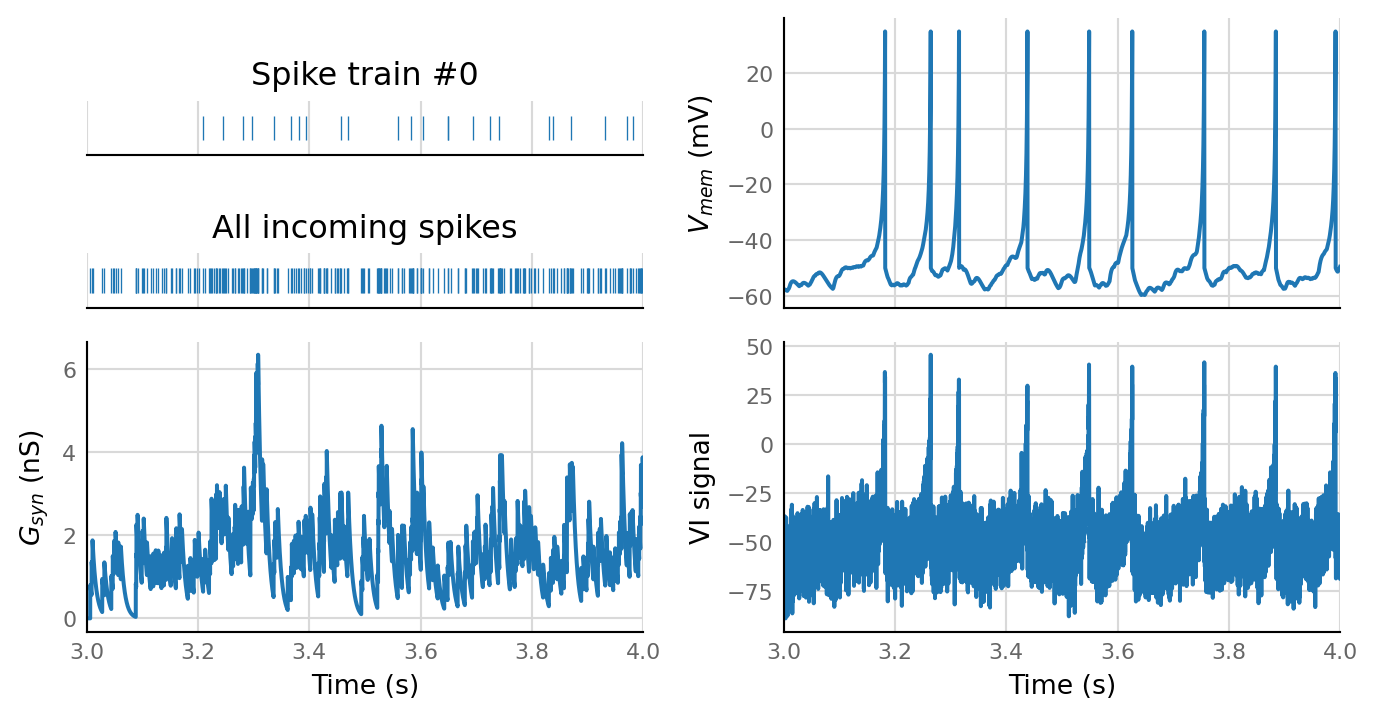

In [10]:
plot_sim_slice(sim_data, t_start=3 * second, duration=1 * second);

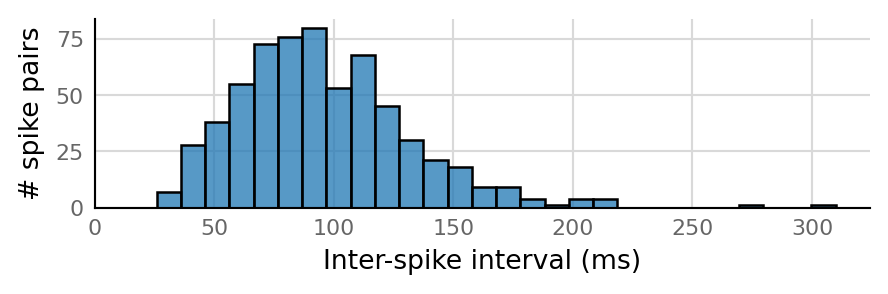

Output spike rate (1 / median ISI): 11 Hz


In [11]:
v.sim.izhikevich_neuron.show_output_spike_stats(sim_data.izh_output);

## Reproducibility

In [14]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `lpxtf3` on `DUIP74576`<br>on **Fri 30 Jul** 2021, at 18:11 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/c2a069f310af39a54add4ad7b65c8ed51ec769d8
) (Fri 30 Jul 2021, 18:00).

Uncommited changes to:
```
 M notebooks/2021-01-13__multiple_ROC.ipynb
 M notebooks/2021-05-25__PGR_conf.ipynb
?? notebooks/2021-07-30__inhibitory.ipynb
```

Platform:

Windows-10
CPython 3.9.6 (C:\miniforge3\python.exe)
Intel(R) Xeon(R) W-2123 CPU @ 3.60GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.21.1
matplotlib           3.4.2
numba                0.53.1
joblib               1.0.1
seaborn              0.11.1
scipy                1.7.0
preload              2.2
nptyping             1.4.2


Full conda list:

```
# packages in environment at C:\miniforge3:
#
# Name                    Version                   Build  Channel
argon2-cffi               20.1.0           py39hb82d6ee_2    conda-forge
async_generator           1.10                       py_0    conda-forge
attrs                     21.2.0             pyhd8ed1ab_0    conda-forge
backcall                  0.2.0              pyh9f0ad1d_0    conda-forge
backports                 1.0                        py_2    conda-forge
backports.functools_lru_cache 1.6.4              pyhd8ed1ab_0    conda-forge
bleach                    3.3.1              pyhd8ed1ab_0    conda-forge
brotlipy                  0.7.0           py39hb82d6ee_1001    conda-forge
ca-certificates           2021.5.30            h5b45459_0    conda-forge
certifi                   2021.5.30        py39hcbf5309_0    conda-forge
cffi                      1.14.6           py39h0878f49_0    conda-forge
chardet                   4.0.0            py39hcbf5309_1    conda-forge
charset-normalizer        2.0.0              pyhd8ed1ab_0    conda-forge
colorama                  0.4.4              pyh9f0ad1d_0    conda-forge
conda                     4.10.3           py39hcbf5309_0    conda-forge
conda-package-handling    1.7.3            py39hb3671d1_0    conda-forge
cryptography              3.4.7            py39hd8d06c1_0    conda-forge
cycler                    0.10.0                   pypi_0    pypi
debugpy                   1.4.1            py39h415ef7b_0    conda-forge
decorator                 5.0.9              pyhd8ed1ab_0    conda-forge
defusedxml                0.7.1              pyhd8ed1ab_0    conda-forge
entrypoints               0.3             pyhd8ed1ab_1003    conda-forge
idna                      3.1                pyhd3deb0d_0    conda-forge
importlib-metadata        4.6.1            py39hcbf5309_0    conda-forge
ipykernel                 6.0.3            py39h832f523_0    conda-forge
ipython                   7.25.0           py39h832f523_1    conda-forge
ipython_genutils          0.2.0                      py_1    conda-forge
jedi                      0.18.0           py39hcbf5309_2    conda-forge
jinja2                    3.0.1              pyhd8ed1ab_0    conda-forge
joblib                    1.0.1                    pypi_0    pypi
jsonschema                3.2.0              pyhd8ed1ab_3    conda-forge
jupyter_client            6.1.12             pyhd8ed1ab_0    conda-forge
jupyter_core              4.7.1            py39hcbf5309_0    conda-forge
jupyterlab_pygments       0.1.2              pyh9f0ad1d_0    conda-forge
kiwisolver                1.3.1                    pypi_0    pypi
libsodium                 1.0.18               h8d14728_1    conda-forge
llvmlite                  0.36.0                   pypi_0    pypi
markupsafe                2.0.1            py39hb82d6ee_0    conda-forge
matplotlib                3.4.2                    pypi_0    pypi
matplotlib-inline         0.1.2              pyhd8ed1ab_2    conda-forge
menuinst                  1.4.17           py39hcbf5309_1    conda-forge
miniforge_console_shortcut 2.0                  h57928b3_0    conda-forge
mistune                   0.8.4           py39hb82d6ee_1004    conda-forge
nbclient                  0.5.3              pyhd8ed1ab_0    conda-forge
nbconvert                 6.1.0            py39hcbf5309_0    conda-forge
nbformat                  5.1.3              pyhd8ed1ab_0    conda-forge
nest-asyncio              1.5.1              pyhd8ed1ab_0    conda-forge
notebook                  6.4.0              pyha770c72_0    conda-forge
nptyping                  1.4.2                    pypi_0    pypi
numba                     0.53.1                   pypi_0    pypi
numpy                     1.21.1                   pypi_0    pypi
openssl                   1.1.1k               h8ffe710_0    conda-forge
packaging                 21.0               pyhd8ed1ab_0    conda-forge
pandas                    1.3.1                    pypi_0    pypi
pandoc                    2.14.1               h8ffe710_0    conda-forge
pandocfilters             1.4.2                      py_1    conda-forge
parso                     0.8.2              pyhd8ed1ab_0    conda-forge
pickleshare               0.7.5                   py_1003    conda-forge
pillow                    8.3.1                    pypi_0    pypi
pip                       21.2.1             pyhd8ed1ab_0    conda-forge
preload                   2.2                      pypi_0    pypi
prometheus_client         0.11.0             pyhd8ed1ab_0    conda-forge
prompt-toolkit            3.0.19             pyha770c72_0    conda-forge
pycosat                   0.6.3           py39hb82d6ee_1006    conda-forge
pycparser                 2.20               pyh9f0ad1d_2    conda-forge
pygments                  2.9.0              pyhd8ed1ab_0    conda-forge
pyopenssl                 20.0.1             pyhd8ed1ab_0    conda-forge
pyparsing                 2.4.7              pyh9f0ad1d_0    conda-forge
pyrsistent                0.17.3           py39hb82d6ee_2    conda-forge
pysocks                   1.7.1            py39hcbf5309_3    conda-forge
python                    3.9.6           h7840368_1_cpython    conda-forge
python-dateutil           2.8.2              pyhd8ed1ab_0    conda-forge
python_abi                3.9                      2_cp39    conda-forge
pytz                      2021.1                   pypi_0    pypi
pywin32                   300              py39hb82d6ee_0    conda-forge
pywinpty                  1.1.3            py39h99910a6_0    conda-forge
pyzmq                     22.1.0           py39he46f08e_0    conda-forge
requests                  2.26.0             pyhd8ed1ab_0    conda-forge
ruamel_yaml               0.15.80         py39hb82d6ee_1004    conda-forge
scipy                     1.7.0                    pypi_0    pypi
seaborn                   0.11.1                   pypi_0    pypi
send2trash                1.7.1              pyhd8ed1ab_0    conda-forge
setuptools                49.6.0           py39hcbf5309_3    conda-forge
six                       1.16.0             pyh6c4a22f_0    conda-forge
sqlite                    3.36.0               h8ffe710_0    conda-forge
terminado                 0.10.1           py39hcbf5309_0    conda-forge
testpath                  0.5.0              pyhd8ed1ab_0    conda-forge
tornado                   6.1              py39hb82d6ee_1    conda-forge
tqdm                      4.61.2             pyhd8ed1ab_1    conda-forge
traitlets                 5.0.5                      py_0    conda-forge
typish                    1.9.2                    pypi_0    pypi
tzdata                    2021a                he74cb21_1    conda-forge
ucrt                      10.0.20348.0         h57928b3_0    conda-forge
urllib3                   1.26.6             pyhd8ed1ab_0    conda-forge
vc                        14.2                 hb210afc_5    conda-forge
voltage-to-wiring-sim     0.1                       dev_0    <develop>
vs2015_runtime            14.29.30037          h902a5da_5    conda-forge
wcwidth                   0.2.5              pyh9f0ad1d_2    conda-forge
webencodings              0.5.1                      py_1    conda-forge
wheel                     0.36.2             pyhd3deb0d_0    conda-forge
win_inet_pton             1.1.0            py39hcbf5309_2    conda-forge
wincertstore              0.2             py39hcbf5309_1006    conda-forge
winpty                    0.4.3                         4    conda-forge
yaml                      0.2.5                he774522_0    conda-forge
zeromq                    4.3.4                h0e60522_0    conda-forge
zipp                      3.5.0              pyhd8ed1ab_0    conda-forge
```